In [1]:
import geometry
import numpy as np
import numba as nb
import ezdxf
import matplotlib.pyplot as plt
import pyperclip

In [2]:
def format_fp(d, N=5):
    """Format a floating point number to N decimal places."""
    return f"{d:.{N}f}"

def path_to_cpp(path: geometry.Path):
    """Convert a Path object to a compact array format for C++."""
    points = path.to_compact_array()

    s = "path *p = path::from_compact_array({\n"
    for point in points:
        s += f"\tcompact_point({format_fp(point[0])}, {format_fp(point[1])}, {format_fp(point[2])}),\n"

    s += "});\n"
    return s



In [3]:
import matplotlib.pyplot as plt

def draw_line(ax, line: geometry.LineSegment, color='k'):
    plt.plot([line.start.x, line.end.x], [line.start.y, line.end.y], color=color)

def draw_arc(ax, arc: geometry.ArcSegment, color='k'):
    # print(f"Start angle: {arc.start_angle}, End angle: {arc.end_angle}, Center: {arc.center}")
    angle = np.linspace(arc.start_angle, arc.end_angle, 72)
    x = arc.center.x + arc.radius * np.cos(angle)
    y = arc.center.y + arc.radius * np.sin(angle)
    ax.plot(x, y, color=color)

def draw_segment(ax, segment: geometry.Segment, color='k'):
    if isinstance(segment, geometry.LineSegment):
        draw_line(ax, segment, color=color)
    elif isinstance(segment, geometry.ArcSegment):
        draw_arc(ax, segment, color=color)

def draw_path(ax, path: geometry.Path):
    if hasattr(path, '__iter__'):
        for p in path:
            draw_path(ax, p)
    else:
        if path.clockwise_winding():
            color = 'r'
        else:
            color = 'b'
        for segment in path.segments():
            draw_segment(ax, segment, color=color)


def load_dxf(filename) -> geometry.Path:
    """Load a DXF file and extract paths from LWPOLYLINE entities."""
    doc = ezdxf.readfile(filename)
    msp = doc.modelspace()

    paths = []
    polylines = msp.query("LWPOLYLINE")
    for path in polylines:
        points = np.array(path.get_points())
        points = points[:, [0, 1, 4]].astype(np.float32)  # x, y, bulge
        paths.append(geometry.Path.from_compact_array(points))

    if len(paths) == 0:
        return None
    elif len(paths) > 1:
        return paths
    else:
        return paths[0]

[{'path1': <geometry.Path at 0x71ee455034d0>,
  'index1': 13,
  'path2': <geometry.Path at 0x71ee455034d0>,
  'index2': 0,
  'point': Vec2D(5.0, 3.2460947036743164)},
 {'path1': <geometry.Path at 0x71ee455034d0>,
  'index1': 7,
  'path2': <geometry.Path at 0x71ee455034d0>,
  'index2': 4,
  'point': Vec2D(5.0, 24.753902435302734)},
 {'path1': <geometry.Path at 0x71ee455034d0>,
  'index1': 12,
  'path2': <geometry.Path at 0x71ee455034d0>,
  'index2': 0,
  'point': Vec2D(5.000000476837158, 3.2460947036743164)},
 {'path1': <geometry.Path at 0x71ee455034d0>,
  'index1': 8,
  'path2': <geometry.Path at 0x71ee455034d0>,
  'index2': 4,
  'point': Vec2D(5.000001430511475, 24.753904342651367)},
 {'path1': <geometry.Path at 0x71ee455034d0>,
  'index1': 15,
  'path2': <geometry.Path at 0x71ee455034d0>,
  'index2': 12,
  'point': Vec2D(5.0, 3.2460947036743164)}]

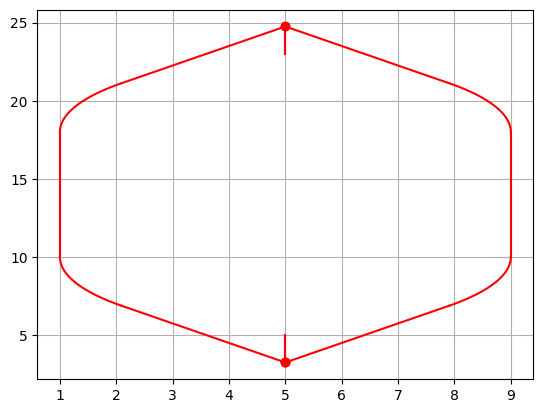

In [4]:
path = load_dxf("dogbone_test.dxf")
path2 = path.offset(-5, cull=False)
draw_path(plt.gca(), path2)
plt.grid()

inter = geometry.intersections(path2)

for i in inter:
    plt.plot(i['point'].x, i['point'].y, 'ro')

inter

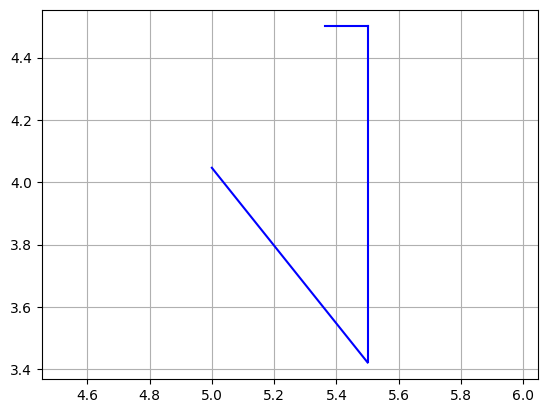

In [67]:
def offset(path, distance: float, arc: bool = True, cull: bool = True):
    if hasattr(path, '__iter__'):
        p = []
        for subpath in path:
            p.extend(offset(subpath, distance, arc, cull))
        return p
    else:
        return path.offset(distance, arc=arc, cull=cull)

path = load_dxf("dogbone_test.dxf")
all_paths = []
total_offset = 0
path = path.offset(-4.5)
draw_path(plt.gca(), path)
plt.axis('equal')
plt.grid()

Total offset: 75.0
[<geometry.Path object at 0x71ee42f0c090>, <geometry.Path object at 0x71ee4546f4b0>]


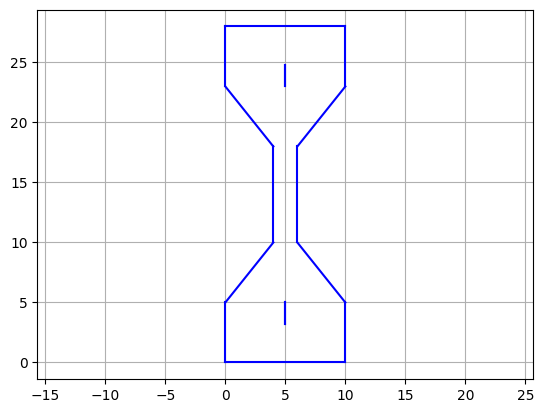

In [47]:
print(f"Total offset: {total_offset:.1f}")
if path:
    all_paths.append(path)
    path = offset(path, -5, cull=True)
    total_offset += 5
    print(path)
else:
    print("Done")

# s = path_to_cpp(path[0])
# print(s)
# pyperclip.copy(s)

# loops = path[0].get_closed_loops()
# %timeit offset(path, -4.5, cull=True)
# # path = offset(path, -0.5, cull=True)
# # path = path2
# # path2 = offset(path, -2.5, cull=True)
draw_path(plt.gca(), all_paths)
plt.axis('equal')
plt.grid()

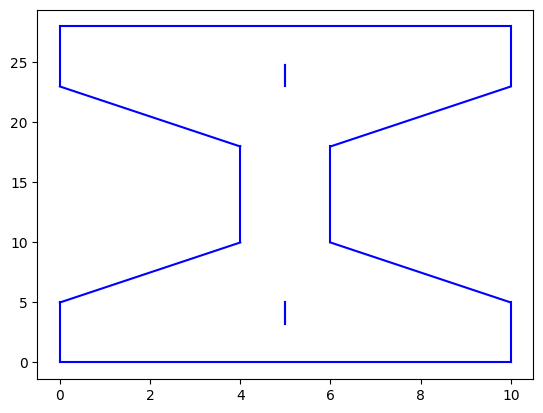

In [7]:
from geometry import intersections, Path, LineSegment, Vec2D

ax = plt.gca()
path = load_dxf("dogbone_test.dxf")
draw_path(ax, path)
path = path.offset(-5)
if not hasattr(path, '__iter__'):
    path = [path]  # Ensure we have a list of paths for intersections

draw_path(ax, path)